# Imports

In [11]:
%load_ext autoreload
%autoreload 2

import os

# import matplotlib.pyplot as plt
# import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
# from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# # Artisinal, small-batch, handmade modules
import classification_metrics
from nb_utils import describe

from celltype_utils import SHARED_CELLTYPES, BROAD_TO_COMPARTMENT, broad_to_compartment
from path_constants import top_hit_paths, FIGURE_FOLDER, sig_outdir_base
from plot_constants import get_cmap_color

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Assign figure folder

In [12]:
figure_folder = os.path.join(FIGURE_FOLDER, "kmermaid_classification_metrics")

## Read in predicted cell data

In [13]:
predicted_cells = pd.read_parquet(
    os.path.join(sig_outdir_base, "aggregated-predicted-cells.parquet")
)
describe(predicted_cells)

(84753, 43)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group,predicted_compartment,groundtruth_compartment
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.086712,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.119992,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.114376,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGGTGTGGTTT,0.181781,B cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGGTGTGGTTT,0.170558,B cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid


# Broad group

## Booststrap and compute score

Use `classification_metrics.subsample_and_score` to randomly sample the data to compute classification metrics.

In [14]:
%%time

scoring_groupby = ['species', 'database_type', 'search_method', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_celltype'
predicted_celltype_col = 'predicted_celltype'

grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=SHARED_CELLTYPES,
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
broad_classification_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(broad_classification_metrics)


100%|██████████| 12/12 [00:00<00:00, 155.74it/s]


(24000, 8)
--- First 5 entries ---


,species,database_type,search_method,alphabet,ksize,score_value,score_name,iteration
0,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.566242,f1_score,0
1,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.244131,adjusted_rand_score,0
2,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.680883,f1_score,1
3,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.241237,adjusted_rand_score,1
4,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.572237,f1_score,2


CPU times: user 777 ms, sys: 1.93 s, total: 2.7 s
Wall time: 55.9 s


In [15]:
broad_classification_metrics["database_method"] = (
    broad_classification_metrics.database_type.astype(str)
    + ": "
    + broad_classification_metrics.search_method.astype(str)
)

In [16]:
species_order = [
    "self",
    "mouse",
    "lemur",
    "human",
    "bat",
]
alphabet_order = "DNA", "protein", "dayhoff"

In [17]:
broad_classification_metrics["alpha_ksize"] = broad_classification_metrics.apply(
    lambda x: "{alphabet}, k: {ksize}".format(**x), axis=1
)

# Compartment

## Booststrap and compute score

In [18]:
broad_to_compartment.unique()

array(['endothelial', 'epithelial', 'lymphoid', 'myeloid', 'stromal'],
      dtype=object)

In [19]:
%%time

scoring_groupby = ['species', 'database_type', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_compartment'
predicted_celltype_col = 'predicted_compartment'


grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=broad_to_compartment.unique(),
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
compartment_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(compartment_metrics)


100%|██████████| 12/12 [00:00<00:00, 179.62it/s]


(24000, 7)
--- First 5 entries ---


,species,database_type,alphabet,ksize,score_value,score_name,iteration
0,bat,min-5-percent-shared-kmers-remove-common-kmers,DNA,21,0.603449,f1_score,0
1,bat,min-5-percent-shared-kmers-remove-common-kmers,DNA,21,0.753363,adjusted_rand_score,0
2,bat,min-5-percent-shared-kmers-remove-common-kmers,DNA,21,0.635131,f1_score,1
3,bat,min-5-percent-shared-kmers-remove-common-kmers,DNA,21,0.210970,adjusted_rand_score,1
4,bat,min-5-percent-shared-kmers-remove-common-kmers,DNA,21,0.857457,f1_score,2


CPU times: user 482 ms, sys: 27.4 ms, total: 509 ms
Wall time: 44.8 s


# Concatenate classification metrics

In [20]:
compartment_metrics.groupby(['species', 'database_type']).size()

species  database_type                                 
bat      min-5-percent-shared-kmers-remove-common-kmers    6000
human    min-5-percent-shared-kmers-remove-common-kmers    6000
lemur    min-5-percent-shared-kmers-remove-common-kmers    6000
mouse    min-5-percent-shared-kmers-remove-common-kmers    6000
dtype: int64

In [21]:
broad_classification_metrics['grouping'] = 'celltype'
compartment_metrics['grouping'] = 'compartment'

In [22]:
broad_classification_metrics.database_type.unique()

array(['min-5-percent-shared-kmers-remove-common-kmers'], dtype=object)

In [23]:
concatenated_metrics = pd.concat([broad_classification_metrics, compartment_metrics])
concatenated_metrics = concatenated_metrics.query(
    'database_type == "min-5-percent-shared-kmers-remove-common-kmers"'
)

describe(concatenated_metrics)

(48000, 11)
--- First 5 entries ---


,species,database_type,search_method,alphabet,ksize,score_value,score_name,iteration,database_method,alpha_ksize,grouping
0,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.566242,f1_score,0,min-5-percent-shared-kmers-remove-common-kmers...,"DNA, k: 21",celltype
1,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.244131,adjusted_rand_score,0,min-5-percent-shared-kmers-remove-common-kmers...,"DNA, k: 21",celltype
2,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.680883,f1_score,1,min-5-percent-shared-kmers-remove-common-kmers...,"DNA, k: 21",celltype
3,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.241237,adjusted_rand_score,1,min-5-percent-shared-kmers-remove-common-kmers...,"DNA, k: 21",celltype
4,bat,min-5-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.572237,f1_score,2,min-5-percent-shared-kmers-remove-common-kmers...,"DNA, k: 21",celltype


In [24]:
concatenated_metrics_folder = os.path.join(
    figure_folder, "concatenated_metrics"
)
! mkdir -p $concatenated_metrics_folder

In [25]:
species_order_no_lemur = ['mouse', 'human', 'bat']


--- min-5-percent-shared-kmers-remove-common-kmers ---


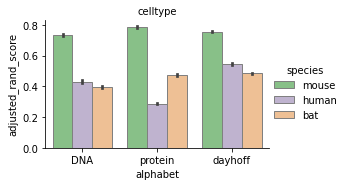

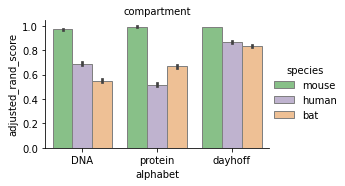

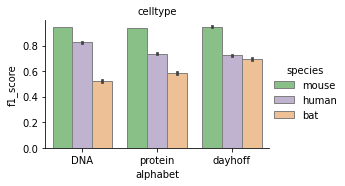

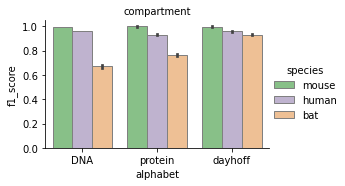

In [26]:
for database_type, database_df in concatenated_metrics.query(
    'species != "lemur"'
).groupby("database_type"):
    print(f"--- {database_type} ---")

    for score_name, score_df in database_df.groupby("score_name"):
        for grouping, df in score_df.groupby("grouping"):
            g = sns.catplot(
                data=df,
                x="alphabet",
                col="grouping",
                y="score_value",
                hue="species",
                kind="bar",
                height=2.5,
                aspect=1.5,
                order=alphabet_order,
                hue_order=species_order_no_lemur,
                palette="Accent",
                linewidth=1,
                edgecolor="grey",
            )
            g.set_titles("{col_name}")
            g.set_ylabels(score_name)
            pdf = os.path.join(
                concatenated_metrics_folder,
                f"barplot_metrics_per_species__row-grouping__hue-species__{database_type}__{score_name}__{grouping}__no_lemur.pdf",
            )
            g.savefig(pdf)